# KSI monitoring: dlouhodobé statistiky napříč ročníky
Tento soubor obsahuje dlouhodobé metriky týkající se počtu řešitelů/úspěšných řešitelů atd. napříč ročníky.

In [2]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from collections import OrderedDict, namedtuple
from sqlalchemy import func, distinct, text, and_
import pandas as pd
import seaborn as sns

import util
from util.year import year
from db import session
import model
from datetime import datetime

plt.rcParams['figure.figsize'] = [6, 5]
print(datetime.now())

2019-05-15 18:18:45.120238


## Počty řešitelů napříč ročníky

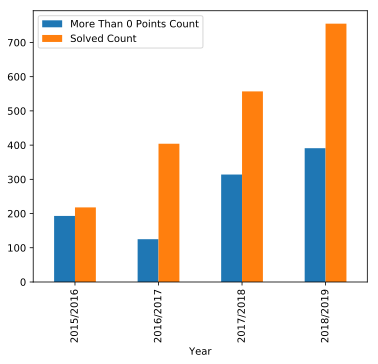

In [9]:
per_module = util.task.points_per_module_all_years().subquery()

per_user = session.query(
    model.Year,
    model.User,
    func.sum(per_module.c.points).label("total_score"),
).\
    join(per_module, model.Year.id == per_module.c.year_id).\
    join(model.User, model.User.id == per_module.c.user_id).\
    filter(model.User.role == 'participant').\
    group_by('year_id', model.User).all()

df = pd.DataFrame(per_user).groupby('Year')
fdf = pd.DataFrame(per_user)
fdf = fdf[fdf['total_score'] > 0].groupby('Year')

per_year = pd.DataFrame({
    'Solved Count': df.total_score.count(),
    'More Than 0 Points Count': fdf.total_score.count(),
})
per_year.plot.bar();

## Histogram získaných bodů napříč ročníky

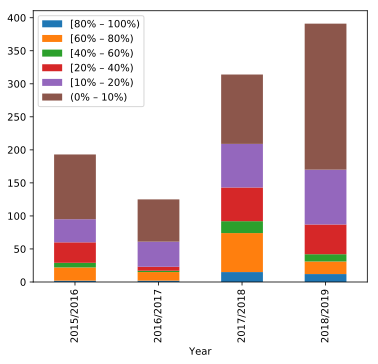

In [11]:
max_points_per_year = util.task.max_points_per_year(bonus=False)

Score = namedtuple('Score', ['Year', 'User', 'RelativePoints'])
relative_per_user = [
    Score(year, user, score / max_points_per_year[year.id][0])
    for year, user, score in per_user
]

fdf = pd.DataFrame(relative_per_user)
fdf = fdf[fdf['RelativePoints'] > 0] # filter 0 points

relative_per_year = pd.DataFrame(OrderedDict((
    ('[80% – 100%)', fdf[fdf['RelativePoints'] >= 0.8].groupby('Year').RelativePoints.count()),
    ('[60% – 80%)', fdf[(fdf['RelativePoints'] >= 0.6) & (fdf['RelativePoints'] < 0.8)].groupby('Year').RelativePoints.count()),
    ('[40% – 60%)', fdf[(fdf['RelativePoints'] >= 0.4) & (fdf['RelativePoints'] < 0.6)].groupby('Year').RelativePoints.count()),
    ('[20% – 40%)', fdf[(fdf['RelativePoints'] >= 0.2) & (fdf['RelativePoints'] < 0.4)].groupby('Year').RelativePoints.count()),
    ('[10% – 20%)', fdf[(fdf['RelativePoints'] >= 0.1) & (fdf['RelativePoints'] < 0.2)].groupby('Year').RelativePoints.count()),
    ('(0% – 10%)', fdf[(fdf['RelativePoints'] >= 0) & (fdf['RelativePoints'] < 0.1)].groupby('Year').RelativePoints.count()),
)))
relative_per_year.plot.bar(stacked=True);

## Počty úspěšných řešitelů

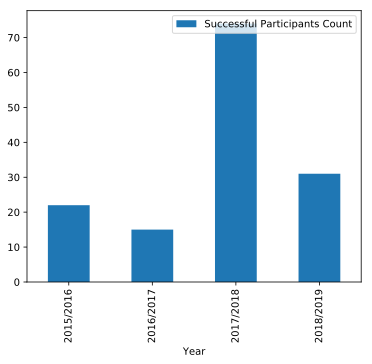

In [74]:
successful_participants = pd.DataFrame({
    'Successful Participants Count': fdf[fdf['RelativePoints'] >= 0.6].groupby('Year').RelativePoints.count(),
})
successful_participants.plot.bar(stacked=True);

## Velké/malé úlohy
Následují data o zastoupení velkých a malých úloh v ročnících.

In [64]:
YearRawData = namedtuple('YearData', ['count', 'points'])

tasks_per_year = session.query(
    model.Year,
    func.count(model.Task.id),
    func.sum(model.Module.max_points).label('sum_points'),
).\
    join(model.Year.tasks).join(model.Task.modules).\
    group_by(model.Year)

big_tasks_per_year = tasks_per_year.\
    filter(model.Module.type == model.ModuleType.GENERAL)

small_tasks_per_year = tasks_per_year.\
    filter(model.Module.type != model.ModuleType.GENERAL)

tasks_per_year_dict = {
    year: YearRawData(count, points)
    for (year, count, points) in tasks_per_year.all()
}
big_tasks_per_year_dict = {
    year: YearRawData(count, points)
    for (year, count, points) in big_tasks_per_year.all()
}
small_tasks_per_year_dict = {
    year: YearRawData(count, points)
    for (year, count, points) in small_tasks_per_year.all()
}

In [65]:
YearData = namedtuple('YearData', [
    'Year', 'small_tasks_points', 'big_tasks_points'
])

year_data = [
    YearData(
        year,
        small_tasks_per_year_dict[year].points,
        big_tasks_per_year_dict[year].points,
    )
    for year in tasks_per_year_dict.keys()
]
year_data.sort(key=lambda yd: yd.Year.id)

In [66]:
df = pd.DataFrame(year_data, columns=[
    'Year',
    'Small Tasks Points',
    'Big Tasks Points',
]).set_index('Year')

### Počet bodů za velké/malé úlohy napříč ročníky

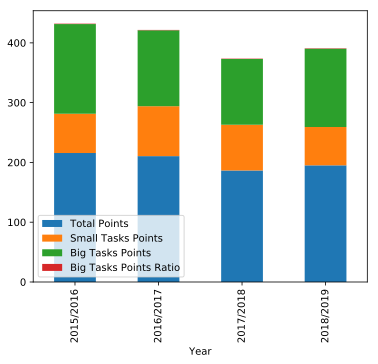

In [75]:
df.plot.bar(stacked=True);

In [68]:
YearData = namedtuple('YearData', [
    'Year', 'tasks_points', 'small_tasks_points', 'big_tasks_points',
    'big_tasks_ratio'
])

year_data = [
    YearData(
        year,
        tasks_per_year_dict[year].points,
        small_tasks_per_year_dict[year].points,
        big_tasks_per_year_dict[year].points,
        big_tasks_per_year_dict[year].points / tasks_per_year_dict[year].points,
    )
    for year in tasks_per_year_dict.keys()
]
year_data.sort(key=lambda yd: yd.Year.id)

In [69]:
df = pd.DataFrame(year_data, columns=[
    'Year',
    'Total Points',
    'Small Tasks Points',
    'Big Tasks Points',
    'Big Tasks Points Ratio',
]).set_index('Year')

s = df.style
s.format({'Big Tasks Points Ratio': '{:,.1%}'.format})
s = s.background_gradient(subset=[
    'Total Points',
    'Small Tasks Points',
    'Big Tasks Points',
    'Big Tasks Points Ratio',
], cmap=sns.light_palette('orange', as_cmap=True))

### Počet bodů za velké/malé úlohy napříč ročníky
Jen data z předchozího grafu v tabulce.

In [70]:
display(s)

,Total Points,Small Tasks Points,Big Tasks Points,Big Tasks Points Ratio
Year,,,,
2015/2016,215.7,65.7,150,69.5%
2016/2017,210.5,83.5,127,60.3%
2017/2018,186.5,76.5,110,59.0%
2018/2019,195.1,64.1,131,67.1%


In [71]:
YearData = namedtuple('YearData', [
    'Year', 'tasks_count', 'small_tasks_count', 'big_tasks_count',
    'big_tasks_ratio'
])

year_data = [
    YearData(
        year,
        tasks_per_year_dict[year].count,
        small_tasks_per_year_dict[year].count,
        big_tasks_per_year_dict[year].count,
        big_tasks_per_year_dict[year].count / tasks_per_year_dict[year].count,
    )
    for year in tasks_per_year_dict.keys()
]
year_data.sort(key=lambda yd: yd.Year.id)

In [52]:
df = pd.DataFrame(year_data, columns=[
    'Year',
    'Tasks Count',
    'Small Tasks Count',
    'Big Tasks Count',
    'Big Tasks Percentage',
]).set_index('Year')

s = df.style
s.format({'Big Tasks Percentage': '{:,.1%}'.format})
s = s.background_gradient(subset=[
    'Tasks Count',
    'Small Tasks Count',
    'Big Tasks Count',
    'Big Tasks Percentage',
], cmap=sns.light_palette('orange', as_cmap=True))

### Počet úloh napříč ročníky

In [152]:
display(s)

,Tasks Count,Small Tasks Count,Big Tasks Count,Big Tasks Percentage
Year,,,,
2015/2016,66,51,15,22.7%
2016/2017,102,89,13,12.7%
2017/2018,81,70,11,13.6%
2018/2019,93,78,15,16.1%
